### concatenate historical with rcp85 for all co-existing models

In [63]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from glob import glob
import os, sys
sys.path.append("/home2/nhn2/py_packages")
from ingrid.times import to_pandas, enso2date
from myplots.cplot import my_contourf
from tqdm import tqdm
from mytools.LG_xarray_tools import xarray_trend
from ingrid.data_clean import ds_clean

In [64]:
# lets get started using the 1x1 degree 40 models that Haibo has on kage:

var = 'ts'

scenario ='historical'
path = '/net/kage/f1/haibo/CMIP5/output/' + scenario + '/atmos/mon/' + var + '/'
files = glob(path + '*/r1i1p1/*.nc')
models1=[]
for file in files:
    models1 = [file.split("/")[-3]] + models1
    
scenario ='rcp85'
path = '/net/kage/f1/haibo/CMIP5/output/' + scenario + '/atmos/mon/' + var + '/'
files = glob(path + '*/r1i1p1/*.nc')
models2=[]
for file in files:
    models2 = [file.split("/")[-3]] + models2
    
# only consider the models which are in common
models = list(set(models1) & set(models2))
print(models)
# let open_mfdataset do the T concatenation, model by model
path = '/net/kage/f1/haibo/CMIP5/output/*/atmos/mon/' + var + '/'
ds = []
for model in models:
    files = glob(path + model + '/r1i1p1/*.nc')
    #print(files)
    dss = xr.open_mfdataset(files,decode_times=False)
    ds = ds + [dss]
    #print(model,'\t',enso2date(dss['T'][0].values),enso2date(dss['T'][-1].values))

['BNU-ESM', 'GISS-E2-R-CC', 'GFDL-ESM2M', 'CESM1-CAM5-1-FV2', 'GISS-E2-H', 'inmcm4', 'CCSM4', 'IPSL-CM5A-LR', 'GFDL-ESM2G', 'IPSL-CM5B-LR', 'MIROC-ESM', 'GISS-E2-H-CC', 'CanESM2', 'HadGEM2-ES', 'GFDL-CM3', 'GISS-E2-R', 'FIO-ESM', 'MRI-CGCM3', 'NorESM1-M', 'bcc-csm1-1-m', 'FGOALS-s2', 'MPI-ESM-MR', 'MIROC5', 'CMCC-CESM', 'ACCESS1-3', 'MPI-ESM-LR', 'CNRM-CM5', 'FGOALS-g2', 'CSIRO-Mk3-6-0', 'CMCC-CMS', 'CMCC-CM', 'CESM1-CAM5', 'ACCESS1-0', 'HadGEM2-CC', 'IPSL-CM5A-MR', 'NorESM1-ME', 'MRI-ESM1', 'bcc-csm1-1', 'CESM1-BGC', 'MIROC-ESM-CHEM']


In [65]:
ds_clean(var,models,ds)

In [66]:
#ds1 = []
#for dss in tqdm(ds):
#    dss = dss.sel(time=slice('1958-01-01', '2015-01-01')).resample(time='AS').mean(dim='time').compute()
#    ds1 = ds1 + [dss]

In [67]:
#dsall = xr.concat(ds1,dim='model')

In [68]:
#dstd = dsall.ts.std(dim=['model']).compute()

In [69]:
#dsall.to_netcdf('ts-Ann-1958-2014.nc')

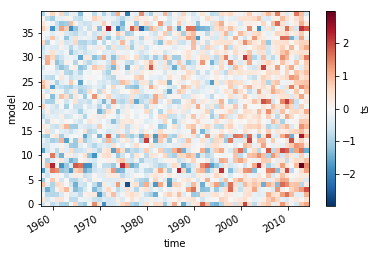

In [82]:
dsall = xr.open_dataset('ts-Ann-1958-2014.nc')
ds_eq = dsall.ts.sel(lon=slice(180,290),lat=slice(-5,5)).mean(['lon','lat'])
(ds_eq - ds_eq.mean('time')).plot()

In [17]:
# test for one model:
dsm1 = dsall.ts[0]
ds_out = xarray_trend(dsm1)
ds_out.slope.plot()

In [31]:
ds_reorder = dsall.ts.transpose('time','model','lat','lon')

In [57]:
#x = dsall.time.to_pandas().index.to_julian_date().values[:, None]
#x[1]-x[0], dsall.time.to_pandas().index.to_julian_date()

In [92]:
ds_trends = xarray_trend(ds_reorder) * 57 * 365  # trend is returned in "per day"
ds_trends.rename({'slope':'trend'},inplace=True)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, model: 40)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
Dimensions without coordinates: model
Data variables:
    trend    (model, lat, lon) float64 1.952 1.838 1.754 1.904 1.889 1.674 ...
    pval     (model, lat, lon) float64 0.04302 0.125 0.2804 0.06644 0.07039 ...

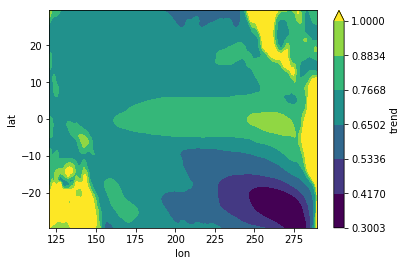

In [94]:
ds_trends.trend.mean('model').sel(lon=slice(120,290),lat=slice(-30,30)).plot.contourf(vmax=1)

(array([ 1.,  2.,  5.,  5.,  4., 10.,  4.,  5.,  3.,  1.]),
 array([0.38461562, 0.47980818, 0.57500075, 0.67019331, 0.76538588,
        0.86057844, 0.95577101, 1.05096357, 1.14615613, 1.2413487 ,
        1.33654126]),
 <a list of 10 Patch objects>)

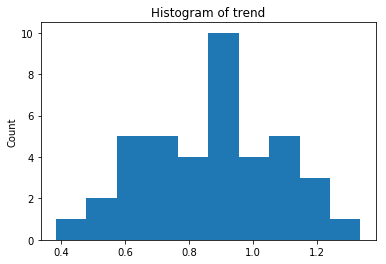

In [96]:
ds_trends.trend.sel(lon=slice(180,290),lat=slice(-5,5)).mean(['lon','lat']).plot.hist()